In [1]:
import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
!pip install kaggle

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
!kaggle competitions download -c nlp-getting-started


  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 29.0MB/s]


In [15]:
!unzip nlp-getting-started.zip


Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
# List files available
print(os.listdir("../input/"))

FileNotFoundError: [Errno 2] No such file or directory: '../input/'

In [17]:
#Training data
train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data has 7613 observations and 5 features including the TARGET (the label we want to predict).

In [18]:
# Testing data
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Note the test data doesn't have the target column

# <a name="eda"></a> 3. Basic EDA

## Missing values

In [19]:
#Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The columns denote the following:

- The `text` of a tweet
- A `keyword` from that tweet
- The `location` the tweet was sent from

In [20]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

A lot of values are missing in the `location` column in both the training and the testing set.

## Exploring the Target Column

* ** Distribution of the Target Column**

We have to predict whether a given tweet is about a real disaster or not. - If so, predict a 1. If not, predict a 0.

In [21]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [22]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette='rocket')

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

* **Exploring the Target Column**
Let's look at what the disaster and the non disaster tweets look like

In [23]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [24]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

## Exploring the 'keyword' column
The keyword column denotes a keyword from the tweet.Let's look at the top 20 keywords in the training data

<Axes: xlabel='count', ylabel='keyword'>

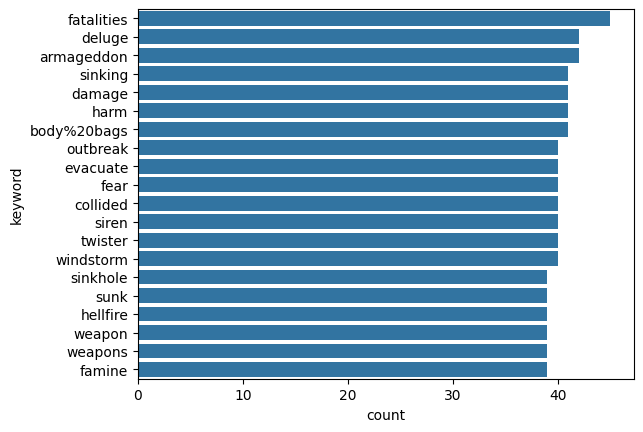

In [25]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

Let's see how often the word 'disaster' come in the dataset and whether this help us in determining whether a tweet belongs to a disaster category or not.

In [26]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

## Exploring the 'location' column
Even though the column `location` has a number of missing values, let's see the top 20 locations present in the dataset. Since some of the locations are repeated, this will require some bit of cleaning.

<Axes: xlabel='count', ylabel='location'>

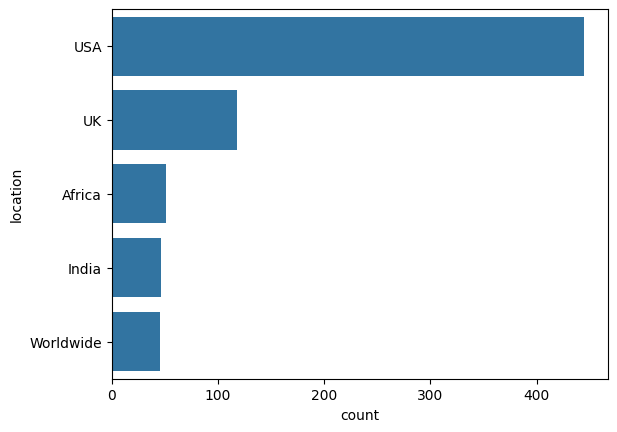

In [27]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

In [28]:
# A quick glance over the existing data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [29]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Just for fun let's create a wordcloud of the clean text to see the most dominating words in the tweets.

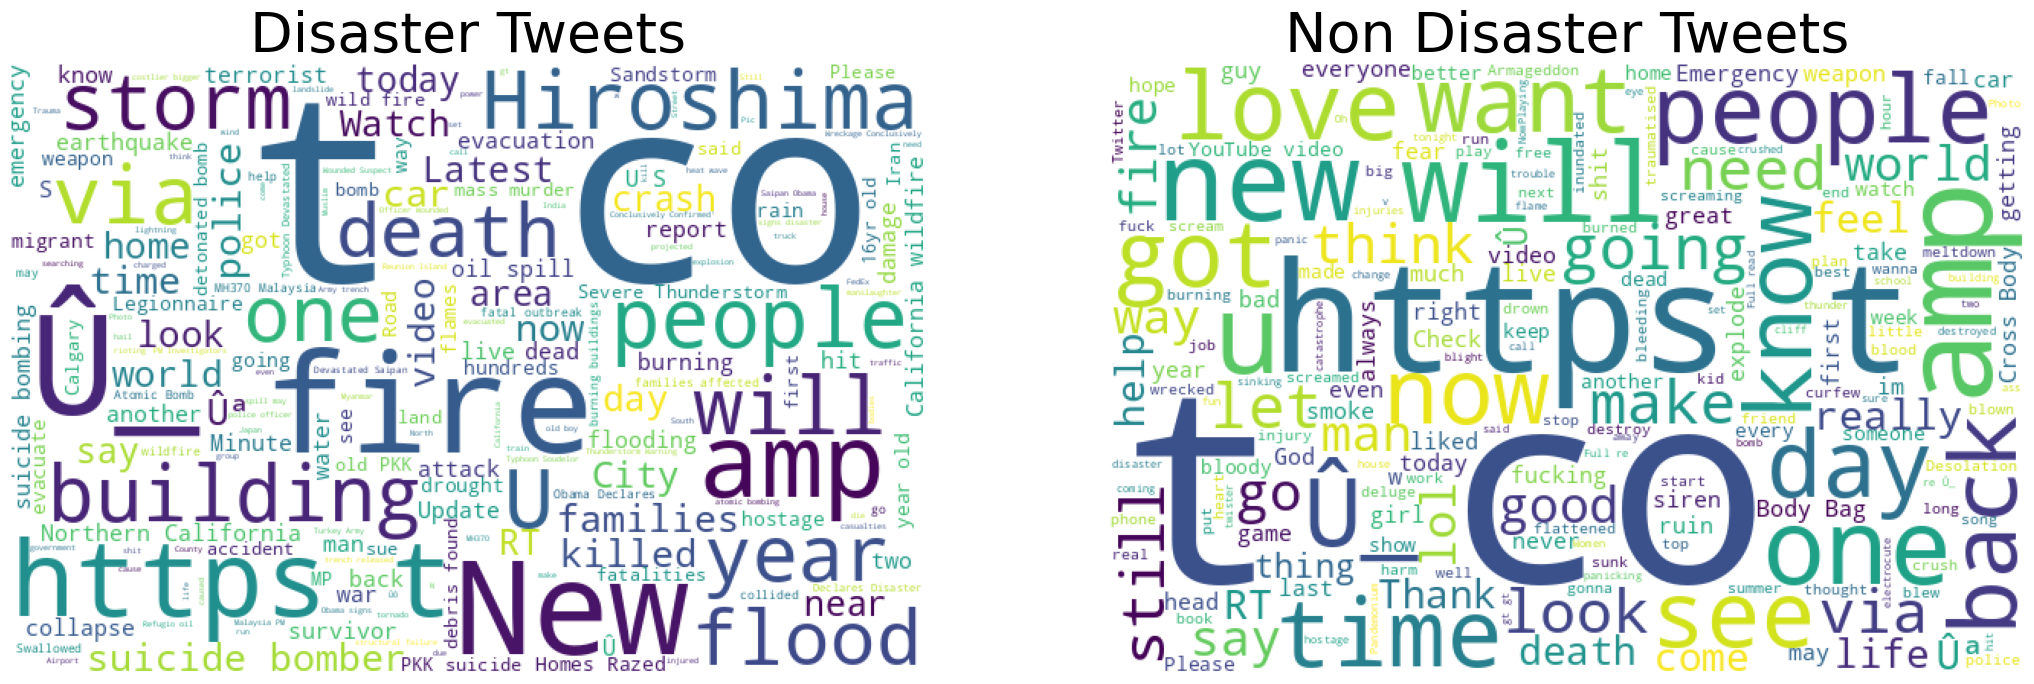

In [30]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

## 2. Tokenization

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. Base upon the type of tokens we want, tokenization can be of various types, for instance

In [31]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [32]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## 3. Stopwords Removal

Now, let's get rid of the stopwords i.e words which occur very frequently but have no possible value like **a, an, the, are **etc.

In [35]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords from NLTK
nltk.download('stopwords')

def remove_stopwords(text):
    """
    Removing stopwords belonging to English language
    """
    stop_words = set(stopwords.words('english'))
    words = [w for w in text.split() if w.lower() not in stop_words]
    return ' '.join(words)

# Ensure the text column is in string format
train['text'] = train['text'].astype(str)
test['text'] = test['text'].astype(str)

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

train.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,"['our', 'deeds', 'are', 'the', 'reason', 'of',...",1
1,4,NaN,NaN,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1
2,5,NaN,NaN,"['all', 'residents', 'asked', 'to', 'shelter',...",1
3,6,NaN,NaN,"['people', 'receive', 'wildfires', 'evacuation...",1
4,7,NaN,NaN,"['just', 'got', 'sent', 'this', 'photo', 'from...",1


## 4. Token normalization

Token normalisation means converting different tokens to their base forms. This can be done either by:

- **Stemming** :  removing and replacing suffixes to get to the root form of the word, which is called the **stem** for instance cats - cat, wolves - wolv
- **Lemmatization** : Returns the base or dictionary form of a word, which is known as the **lemma**

[*source*](https://www.coursera.org/learn/language-processing/lecture/SCd4G/text-preprocessing)

In [37]:
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

text = "feet cats wolves talked"
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer = WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


It is important to note here that stemming and lemmatization sometimes donot necessarily improve results as at times we donot want to trim words but rather preserve their original form. Hence their usage actually differs from problem to problem. For this problem, I will not use these techniques.

In [38]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[ ' o u r ' , ' d e e d s ' , ' a r e ' , ...",1
1,4,NaN,NaN,"[ ' f o r e s t ' , ' f i r e ' , ' n e a ...",1
2,5,NaN,NaN,"[ ' a l l ' , ' r e s i d e n t s ' , ' a ...",1
3,6,NaN,NaN,"[ ' p e o p l e ' , ' r e c e i v e ' , ' ...",1
4,7,NaN,NaN,"[ ' j u s t ' , ' g o t ' , ' s e n t ' , ...",1


### Getting it all together- A Text Preprocessing Function
This concludes the pre-processing part. It will be prudent to convert all the steps undertaken into a function for better reusability.

In [39]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Example check on a few documents
sample_texts = train['text'].iloc[:10].tolist()  # Adjust the slice as needed

# Print out the sample_texts to inspect them
print("Sample texts:", sample_texts)

# Initialize CountVectorizer with stop_words=None to disable default stop words removal
count_vectorizer = CountVectorizer(stop_words=None)

# Fit-transform on the sample_texts
try:
    train_vectors = count_vectorizer.fit_transform(sample_texts)
except ValueError as e:
    print("ValueError:", e)

# Check vocabulary size and inspect some terms if fit_transform succeeds
if 'train_vectors' in locals():
    print("Vocabulary size:", len(count_vectorizer.vocabulary_))
    print("Some vocabulary terms:", list(count_vectorizer.vocabulary_.keys())[:10])


Sample texts: ["[ ' o u r ' ,   ' d e e d s ' ,   ' a r e ' ,   ' t h e ' ,   ' r e a s o n ' ,   ' o f ' ,   ' t h i s ' ,   ' e a r t h q u a k e ' ,   ' m a y ' ,   ' a l l a h ' ,   ' f o r g i v e ' ,   ' u s ' ,   ' a l l ' ]", "[ ' f o r e s t ' ,   ' f i r e ' ,   ' n e a r ' ,   ' l a ' ,   ' r o n g e ' ,   ' s a s k ' ,   ' c a n a d a ' ]", "[ ' a l l ' ,   ' r e s i d e n t s ' ,   ' a s k e d ' ,   ' t o ' ,   ' s h e l t e r ' ,   ' i n ' ,   ' p l a c e ' ,   ' a r e ' ,   ' b e i n g ' ,   ' n o t i f i e d ' ,   ' b y ' ,   ' o f f i c e r s ' ,   ' n o ' ,   ' o t h e r ' ,   ' e v a c u a t i o n ' ,   ' o r ' ,   ' s h e l t e r ' ,   ' i n ' ,   ' p l a c e ' ,   ' o r d e r s ' ,   ' a r e ' ,   ' e x p e c t e d ' ]", "[ ' p e o p l e ' ,   ' r e c e i v e ' ,   ' w i l d f i r e s ' ,   ' e v a c u a t i o n ' ,   ' o r d e r s ' ,   ' i n ' ,   ' c a l i f o r n i a ' ]", "[ ' j u s t ' ,   ' g o t ' ,   ' s e n t ' ,   ' t h i s ' ,   ' p h o t o ' ,   ' f r 

In [46]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

In [ ]:
clf.fit(train_vectors, train["target"])

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

It appears the countvectorizer gives a better performance than TFIDF in this case.

## Naives Bayes Classifier
Well, this is a decent score. Let's try with another model that is said to work well with text data : Naive Bayes.

In [ ]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

In [ ]:
clf_NB.fit(train_vectors, train["target"])

In [ ]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

well the naive bayes on TFIDF features scores much better than logistic regression model.

In [ ]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

## XGBoost

In [ ]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

In [ ]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores



## Making the submission

In [ ]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [ ]:
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)